<h1 style="background-color:#0071BD;color:white;text-align:center;padding-top:0.8em;padding-bottom: 0.8em">
    Training Neural Networks <i>Without</i> Backpropagation
</h1>

Accompanying notebook for the NumPy / SciPy Recipes for Data Science:

  * Christian Bauckhage: "Training Neural Networks Without Backpropagation", B-IT, University of Bonn, February 2019 ([Download from ResearchGate](https://www.researchgate.net/publication/322254761_NumPy_SciPy_Recipes_for_Data_Science_Training_Neural_Networks_Without_Backpropagation))
  * Abstract of the paper: *We practically demonstrate that error backpropagation is not the only way to train multi-layered (deep) neural networks. To this end, we first discuss derivative-free optimization in general and the SPSA algorithm in particular. We then present a simple SPSA-based algorithm for neural network training and show how to implement it using only a few lines of NumPy code.* 

<p style="background-color:#66A5D1;padding-top:0.2em;padding-bottom: 0.2em" />

In [1]:
import numpy as np
import numpy.random as rnd

import matplotlib.pyplot as plt
import matplotlib.colors as clr

from functools import partial

## Plotting Utilities

In [2]:
blue   = '#0059ff' # hsv(219., 1., 1. )
orange = '#ffa500' # hsv( 39., 1., 1. )

def make_blue_orange_colormap():
    (ora_r, ora_g, ora_b) = clr.ColorConverter().to_rgb(orange)
    (blu_r, blu_g, blu_b)  = clr.ColorConverter().to_rgb(blue)
    cdict = {'red':   [(0.0,  None, ora_r), (0.5,  1.0, 1.0), (1.0,  blu_r, None)],
             'green': [(0.0,  None, ora_g), (0.5,  1.0, 1.0), (1.0,  blu_g, None)],
             'blue':  [(0.0,  None, ora_b), (0.5,  1.0, 1.0), (1.0,  blu_b, None)]}
    return clr.LinearSegmentedColormap('BluOra', cdict)

BluOra = make_blue_orange_colormap()

In [3]:
def plot_classes(axs, X, y, classes=[-1, +1], colors=[orange, blue]):
    assert len(classes) == len(colors), "We need one color per class."
    for cls, col in zip(classes, colors):
        axs.plot(X[0, y==cls], X[1, y==cls], 'o', color=col, ms=7, mew=1, alpha=0.5)
    
def plot_classifier(axs, classifier, lims):
    xmin, xmax, ymin, ymax = lims
    dx = xmax-xmin; dy = ymax-ymin
    nx = 512; ny = int(nx * dy/dx)
    xs, ys = np.meshgrid(np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny))
    Z = np.vstack((xs.flatten(), ys.flatten()))
    Y = classifier(Z)
    Y = Y.reshape(ny, nx)
    axs.imshow(Y, interpolation='nearest', origin='lower', extent=(xmin, xmax, ymin, ymax), cmap=BluOra, alpha=0.25)

def plot_error(axs, X, y, classifier):
    axs.scatter(X[0, :], X[1, :], c=(y-classifier(X))[0], vmin=-2, vmax=+2, cmap='seismic', alpha=0.5)

    
def init_plots(n, lims=None):
    f, [axs] = plt.subplots(1, n, figsize = (18, min(5, 18/n)), squeeze=False)
    for a in axs:
        a.spines['left'].set_position('zero')
        a.spines['left'].set_zorder(1)
        a.spines['bottom'].set_position('zero')
        a.spines['bottom'].set_zorder(1)
        a.spines['right'].set_visible(False)
        a.spines['top'].set_visible(False)
        a.xaxis.set_ticks_position('bottom')
        a.yaxis.set_ticks_position('left')
        a.tick_params(direction='out')
        a.set_xlim(lims[0],lims[1])
        a.set_ylim(lims[2],lims[3])
        a.set_aspect(aspect='equal', adjustable='box')
    return axs[0] if len(axs) == 1 else axs

def done_plots():
    plt.show()
    plt.close()    

## Creating Training Data

In [4]:
def generateXorTrainingData(n1, n2):
    X1 = rnd.randn(2, n1//2) * 0.2 + np.array([[-1],[ 1]])
    X2 = rnd.randn(2, n1//2) * 0.2 + np.array([[ 1],[-1]])
    X3 = rnd.randn(2, n2//2) * 0.2 + np.array([[ 1],[ 1]])
    X4 = rnd.randn(2, n2//2) * 0.2 + np.array([[-1],[-1]])
    y1 = np.ones(n1)
    y2 = -np.ones(n2)
    return np.hstack((X1, X2, X3, X4)), np.hstack((y1, y2))

In [5]:
X, y = generateXorTrainingData(100, 100)

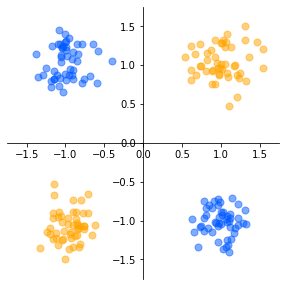

In [6]:
lims = [-1.75, 1.75, -1.75, 1.75]

axs = init_plots(1, lims)
plot_classes(axs, X, y, [-1, +1])
done_plots()

## Initialization of Neural Network Parameters

In [7]:
def initNet(idim, hdims, odim, bias=True):
    '''
    initializes a multilayer neural network
    parameters:
        idim  : dimension  of input layer
        hdims : dimensions of hidden layers
        odim  : dimension  of output layer
    returns:
        weights : list of weight matrices
        activation : activation function
    '''
    
    def activation(s):
        return np.tanh(0.5*s)
    
    dims = [idim] + hdims + [odim]
    
    weights = []
    for l in range(1, len(dims)):
        numcols = dims[l-1]
        numrows = dims[l]
        if bias:
            numcols += 1
        weights.append(rnd.randn(numrows, numcols))
    
    return weights, activation

In [8]:
W, f = initNet(2, [5, 5, 5], 1)

## Running the Neural Network

In [9]:
def runNet(data, weights, activation, bias=True):
    '''
    runs a neural network on input data
    parameters:
        data : input data (a whole column matrix or a single column vector)
        weights : list of weight matrices of the network
        activation : activation function of the network
    returns:
        s_out : matrix, vector, or scalar of network outputs for the inputs
    '''
    
    s_in = data
    
    for weight in weights:
        m, n = s_in.shape
        if bias:
            s_in = np.vstack((np.ones(n), s_in))
        s_out = activation(weight.dot(s_in))
        s_in = s_out
    
    return s_out

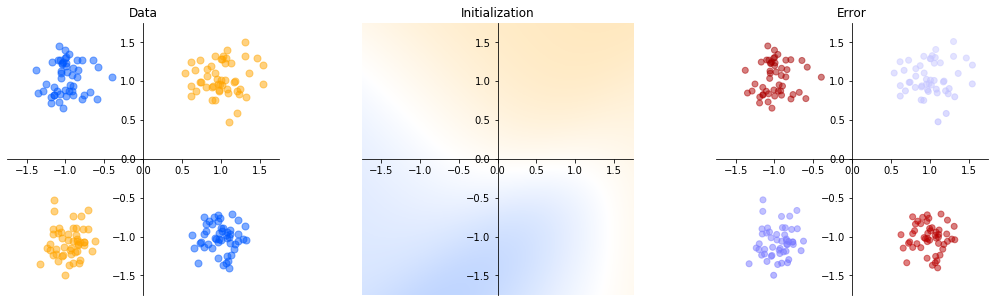

In [10]:
axs = init_plots(3, lims)

axs[0].set_title('Data')
plot_classes(axs[0], X, y, [-1, +1])

axs[1].set_title('Initialization')
plot_classifier(axs[1], lambda data: runNet(data, W, f), lims)

axs[2].set_title('Error')
plot_error(axs[2], X, y, lambda data: runNet(data, W, f))

done_plots()

##  Evaluating the Neural Network

In [11]:
def evalNet(data, labels, weights, activation, bias=True):
    '''
    evaluates a neural network’s performance
    parameters:
        data : input data
        labels : input labels
        weights : weight matrices
        activation : activation function
    returns:
        error value according to equation (8)
    '''
    
    return np.sum((runNet(data, weights, activation, bias=bias) - labels)**2)

In [12]:
print(evalNet(X, y, W, f))

272.8215158164979


##  Training the Neural Network

In [13]:
def trainNetSPSA(data, labels, weights, activation, bias=True, emax=50, tmax=25, a=0.01, alpha=1.0, c=0.01, gamma=0.4,
                 show = lambda e, weights, activation: None):
    '''
    trains a neural network using the SPSA-based Algorithm 2
    parameters:
        data : training data
        labels : training labels
        weights : weight matrices
        activation : activation function
    returns:
        weight : optimized network weights
    '''

    # perform emax epochs of training
    for e in range(emax):
        
        # bottom-up iterate (sic!) over the layers of the network
        for l in range(len(weights)):
            
            W_p = np.copy(weights)
            W_m = np.copy(weights)
        
            # keeping matrices W[k!=l] fixed, use SPSA to optimize matrix W[l]
            for t in range(1,tmax):
                a_t = a / t**alpha
                c_t = c / t**gamma
            
                delta = rnd.binomial(1, p=0.5, size=(weights[l].shape)) * 2. - 1
            
                W_p[l] = weights[l] + c_t * delta
                W_m[l] = weights[l] - c_t * delta
            
                eval_p = evalNet(data, labels, W_p, activation)
                eval_m = evalNet(data, labels, W_m, activation)
            
                ghat = (eval_p - eval_m) / (2 * c_t * delta)
                
                weights[l] = weights[l] - a_t * ghat
        _                                                                          ; show(e, weights, activation)

    return weights

In [14]:
def show_updated_classifier(n_cols, X, y, 
                            epoch, weights, activation):
    global col, axs
    
    if epoch == 0: col = 0
    if col == 0: axs = init_plots(n_cols, lims)
    a = axs[col]
    
    a.set_title('Epoch {}: error={:.3}'.format(epoch, evalNet(X, y, weights, activation)))
    plot_classifier(a, lambda Z: runNet(Z, W, f), lims)
    plot_classes(a, X, y, [-1, +1])
    
    col += 1
    if col == n_cols: 
        done_plots(); col = 0    

In [15]:
show = partial(show_updated_classifier, 4, X, y)
W0, f0 = np.copy(W), f # Remember from where we started

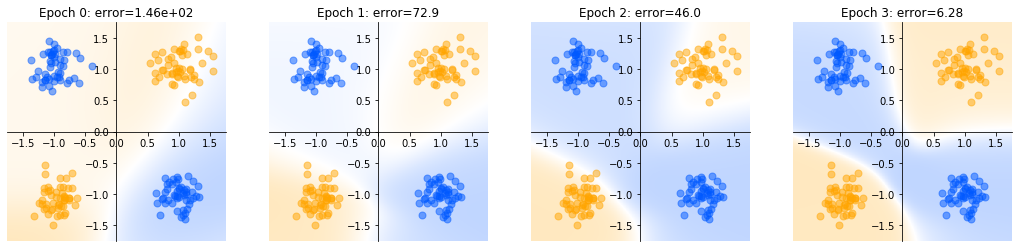

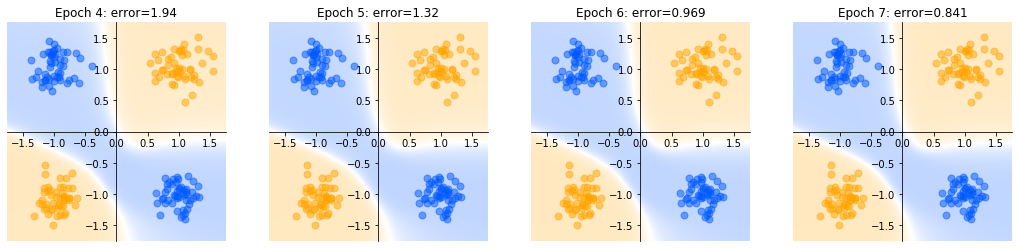

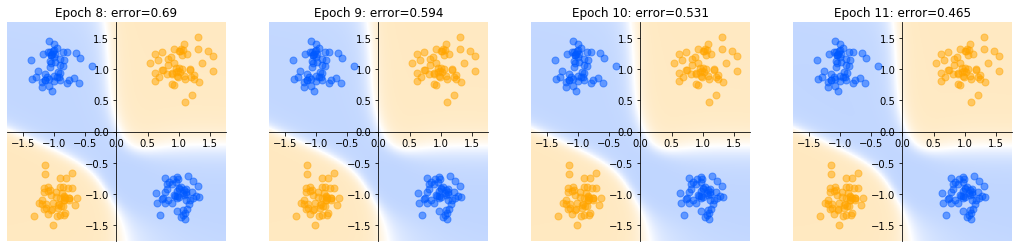

In [16]:
epochs = 12
W = trainNetSPSA(X, y, W, f, emax=epochs, show=show)

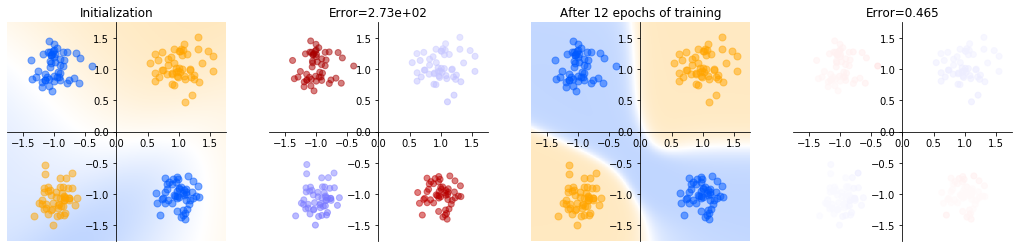

In [17]:
axs = init_plots(4, lims)

axs[0].set_title('Initialization')
plot_classifier(axs[0], lambda Z: runNet(Z, W0, f0), lims)
plot_classes(axs[0], X, y, [-1, +1])

axs[1].set_title('Error={:.3}'.format(evalNet(X, y, W0, f0)))
plot_error(axs[1], X, y, lambda data: runNet(data, W0, f0))

axs[2].set_title('After {} epochs of training'.format(epochs))
plot_classifier(axs[2], lambda Z: runNet(Z, W, f), lims)
plot_classes(axs[2], X, y, [-1, +1])

axs[3].set_title('Error={:.3}'.format(evalNet(X, y, W, f)))
plot_error(axs[3], X, y, lambda data: runNet(data, W, f))

done_plots()

<table style="width:100%">
  <tr>
      <td colspan="1" style="text-align:left;background-color:#0071BD;color:white">
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">
            <img alt="Creative Commons License" style="border-width:0;float:left;padding-right:10pt"
                 src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" />
        </a>
        &copy; C. Bauckhage and D. Speicher<br/>
        Licensed under a 
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/" style="color:white">
            CC BY-NC 4.0
        </a>.
      </td>
      <td colspan="2" style="text-align:left;background-color:#66A5D1">
          <b>Acknowledgments:</b>
          This material was prepared within the project
          <a href="http://www.b-it-center.de/b-it-programmes/teaching-material/p3ml/" style="color:black">
              P3ML
          </a> 
          which is funded by the Ministry of Education and Research of Germany (BMBF)
          under grant number 01/S17064. The authors gratefully acknowledge this support.
      </td>
  </tr>
</table>